In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import itertools
from scipy.stats import spearmanr
from itertools import combinations

In [27]:
Stage=3
folder_name='experiment and result stage'+str(Stage)
Dataset="Baseline GTSRB" #if baseline then Basline .../...
baseline='3*3'

if baseline:
  x=Dataset+" "+baseline
  filename="Copy of " + x + "_result.csv"
else:
  filename="Copy of " + Dataset + "_result.csv"

methods=['deeplift', 'integrated_gradients']
method='deeplift'
flops_dict = {"branch1": 221, "branch2": 221, "branch3": 221, "totalFLOPS": 1852}
end_epoch=0

In [28]:
load_file_path='/content/drive/My Drive/2023 InterpretingNN/code/'+folder_name+'/'+Dataset+'/'+filename
print(load_file_path)
save_folder='/content/drive/My Drive/2023 InterpretingNN/code/'+folder_name+'/'+Dataset+'/processed data/'
print(save_folder)

/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage3/Baseline GTSRB/Copy of Baseline GTSRB 3*3_result.csv
/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage3/Baseline GTSRB/processed data/


In [29]:
# Load the CSV file into a dataframe
dataframe = pd.read_csv(load_file_path)

add flops col

In [30]:
def preprocess_dataframe(df, flops_dict):
    df.rename(columns={'branch1.0': 'branch1', 'branch2.0': 'branch2', 'branch3.0': 'branch3', 'branch4.0': 'branch4'}, inplace=True)

    # Add FLOPS columns
    for col, value in flops_dict.items():
        df[col+"FLOPS"] = value
    return df
df = preprocess_dataframe(dataframe, flops_dict)

normalize layer feature attribution in this stack

In [31]:
def normalize_feature_attribution(df, threshold=70):
    layers=['branch1','branch2','branch3','branch4']

    # New sum calculation using specific layers
    df['sum_feature_attr'] = df[layers].sum(axis=1)

    # Normalize each layer by dividing by the new sum of feature attributions
    for layer in layers:
        df[f'norm_{layer}'] = df[layer] / df['sum_feature_attr']


    df.drop(['sum_feature_attr','branch1','branch2','branch3','branch4'], axis=1, inplace=True)

    # delete data with 70 or lower acc
    epoch_3_accuracy_cols = ['test accuracy epoch'+str(end_epoch)]
    df['final_test_accuracy'] = df[epoch_3_accuracy_cols].mean(axis=1)

    # Filter the dataframe based on the threshold
    filtered_df = df[df['final_test_accuracy'] >= threshold]

    return df

normalized_df = normalize_feature_attribution(df.copy())

In [32]:
normalized_df

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,train accuracy epoch0,train accuracy epoch1,train accuracy epoch2,test accuracy epoch0,...,run,branch1FLOPS,branch2FLOPS,branch3FLOPS,totalFLOPSFLOPS,norm_branch1,norm_branch2,norm_branch3,norm_branch4,final_test_accuracy
0,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,72.526276,91.865616,94.414414,71.654790,...,0,221,221,221,1852,0.252957,0.336907,0.234982,0.175154,71.654790
1,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,72.526276,91.865616,94.414414,71.654790,...,0,221,221,221,1852,0.252916,0.336882,0.235044,0.175158,71.654790
2,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,73.712462,91.509009,94.358108,76.627078,...,1,221,221,221,1852,0.283365,0.209269,0.338720,0.168646,76.627078
3,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,73.712462,91.509009,94.358108,76.627078,...,1,221,221,221,1852,0.283369,0.209258,0.338722,0.168651,76.627078
4,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,71.936937,91.223724,94.174174,71.100554,...,2,221,221,221,1852,0.228901,0.248017,0.361396,0.161687,71.100554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,76.024775,91.651652,94.789790,76.183690,...,12,221,221,221,1852,0.086829,0.427126,0.355424,0.130621,76.183690
356,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,77.169670,92.173423,94.984985,75.851148,...,13,221,221,221,1852,-0.036858,0.528731,0.225906,0.282222,75.851148
357,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,77.169670,92.173423,94.984985,75.851148,...,13,221,221,221,1852,-0.036688,0.528728,0.225862,0.282098,75.851148
358,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,75.990991,91.659159,94.328078,76.737926,...,14,221,221,221,1852,0.283529,0.296634,0.230792,0.189045,76.737926


get standard deviation for each layer's feature attribution

In [33]:
def get_FA_SD(df, method, flops_dict):
    # Filter the dataframe based on the method
    filtered_df = df[df['method'] == method]

    # Columns for which to calculate average and normalized variance, excluding certain layers
    layers = ['norm_branch1','norm_branch2','norm_branch3','norm_branch4']
    accuracy_columns = ['train accuracy epoch'+str(end_epoch), 'test accuracy epoch'+str(end_epoch)]

    # Group by hyperparameters and calculate mean and variance for feature attributions and accuracy
    grouped = filtered_df.groupby(['initial_lr', 'optimizer', 'criterion', 'train_data_used', 'train_set_shuffle', 'train_batch_size'])
    avg_norm = grouped[layers].mean()
    var = grouped[layers].var()
    std = grouped[layers].std()
    avg_acc = grouped[accuracy_columns].mean()

    # Combine average and normalized variance into one dataframe
    combined_df = avg_norm.copy()
    for layer in layers:
        combined_df[f'std_{layer}'] = std[layer]

    # Calculate the average normalized variance across the selected layers
    std_layers = [f'std_{layer}' for layer in layers]
    combined_df['avg_std'] = combined_df[std_layers].mean(axis=1)

    # Adding average accuracy columns
    for acc_col in accuracy_columns:
        combined_df[acc_col] = avg_acc[acc_col]

    # Add FLOPS information
    for flops_key, flops_value in flops_dict.items():
        combined_df[flops_key] = flops_value

    return combined_df

# Example usage
FA_SD = get_FA_SD(normalized_df, method, flops_dict)

In [34]:
FA_SD.to_csv(save_folder+"/"+method+" "+Dataset+str(baseline)+" all_FA_SD.csv")
FA_SD=pd.read_csv(save_folder+"/"+method+" "+Dataset+str(baseline)+" all_FA_SD.csv")

In [35]:
FA_SD

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,norm_branch1,norm_branch2,norm_branch3,norm_branch4,...,std_norm_branch2,std_norm_branch3,std_norm_branch4,avg_std,train accuracy epoch0,test accuracy epoch0,branch1,branch2,branch3,totalFLOPS
0,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,0.273669,0.253748,0.272446,0.200137,...,0.169325,0.136650,0.087932,0.152335,76.286036,75.397730,221,221,221,1852
1,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.284352,0.270823,0.302079,0.142746,...,0.104985,0.098454,0.034103,0.089997,74.775526,75.227237,221,221,221,1852
2,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,32,0.272671,0.279797,0.309711,0.137821,...,0.097263,0.089320,0.030581,0.081629,71.512513,72.895751,221,221,221,1852
3,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,0.275083,0.268568,0.307213,0.149136,...,0.102697,0.084541,0.032997,0.083821,66.473473,68.805490,221,221,221,1852
4,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,0.221875,0.280284,0.253281,0.244560,...,0.074419,0.086373,0.035776,0.079056,74.910911,74.073898,221,221,221,1852
5,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.240347,0.270353,0.275540,0.213759,...,0.123935,0.075610,0.060405,0.095985,75.848599,75.222486,221,221,221,1852
6,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,32,0.255695,0.277435,0.283798,0.183072,...,0.094956,0.089720,0.034309,0.085505,75.190691,75.377672,221,221,221,1852
7,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,0.261588,0.276194,0.299222,0.162996,...,0.082359,0.071720,0.030854,0.069036,72.689189,73.885458,221,221,221,1852
8,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,0.223787,0.285053,0.275008,0.216152,...,0.072791,0.091210,0.031530,0.068147,72.842843,71.808393,221,221,221,1852
9,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.221185,0.280071,0.279423,0.219321,...,0.081318,0.096496,0.060317,0.089283,74.578829,74.078121,221,221,221,1852


# Graph

In [36]:
def plot_variance_for_multiple_hyperparam_values(df, hyperparam, variables):
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = ['std_norm_branch1',	'std_norm_branch2',	'std_norm_branch3',	'std_norm_branch4', 'avg_std']

    # Preparing data for plotting
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var]
        avg_variances = subset[variance_columns].mean().to_frame().T
        avg_variances['hyperparam_value'] = var
        plot_data = pd.concat([plot_data, avg_variances])

    plot_data.set_index('hyperparam_value', inplace=True)

    # Plotting average variance for each layer and overall average
    plot_data.plot(kind='bar')
    plt.title(f'Average Variance for Different {hyperparam} Values')
    plt.ylabel('Average Variance')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.show()


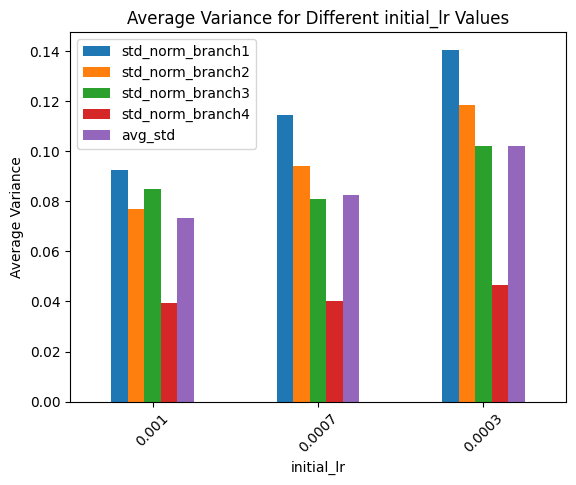

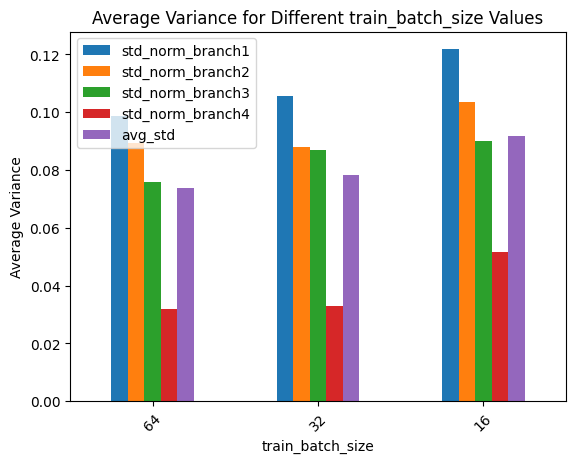

In [37]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_batch_size': [64, 32, 16]
}
for hyperparam, variables in hyperparams_choice_list.items():
    plot_variance_for_multiple_hyperparam_values(FA_SD, hyperparam, variables)

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bee_swarm_for_norm_fa(df, hyperparam, variables):
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = ['norm_branch1', 'norm_branch2', 'norm_branch3', 'norm_branch4']

    # Preparing data for plotting in long format
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var][variance_columns]
        subset = subset.melt(var_name='Branch', value_name='Variance')
        subset[hyperparam] = var
        plot_data = pd.concat([plot_data, subset])

    # Creating the bee swarm plot
    plt.figure(figsize=(10, 6))
    sns.swarmplot(x=hyperparam, y='Variance', hue='Branch', data=plot_data)
    plt.title(f'Bee Swarm Plot of Variances for Different {hyperparam} Values')
    plt.ylabel('Feature Attribution')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.legend(title='Branch')
    plt.show()


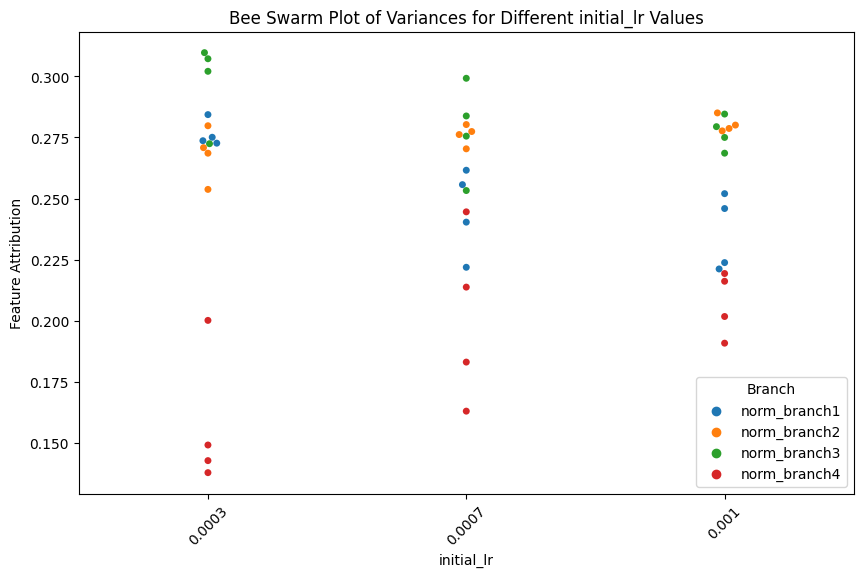

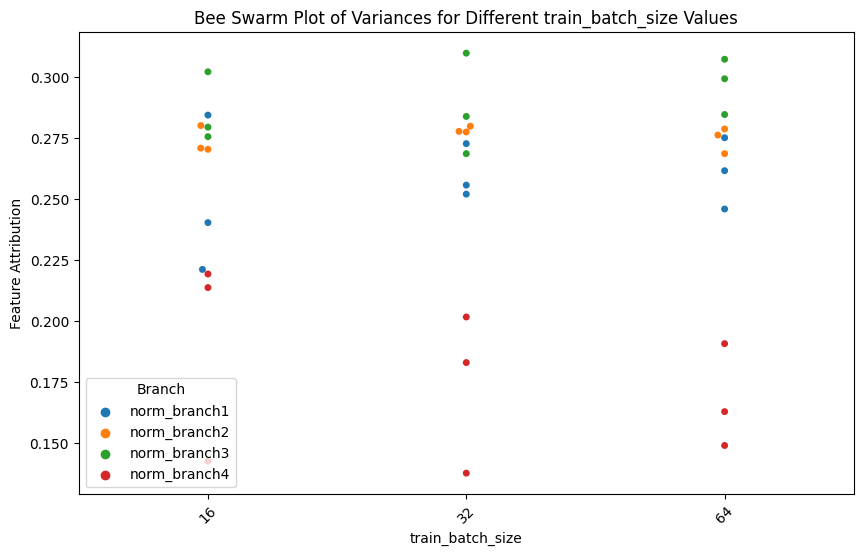

In [39]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_batch_size': [64, 32, 16]
}
for hyperparam, variables in hyperparams_choice_list.items():
    plot_bee_swarm_for_norm_fa(FA_SD, hyperparam, variables)

# Paired T test

In [40]:
def one_sided_paired_ttest(data_set1, data_set2):
    """
    Perform a one-sided paired t-test to determine if the first data set is statistically larger than the second.

    Parameters:
    data_set1 (array-like): The first set of data.
    data_set2 (array-like): The second set of data.

    Returns:
    tuple: A tuple containing the t-statistic and the one-sided p-value.
    """
    t_statistic, p_value = ttest_rel(data_set1, data_set2)

    # Adjust p-value for one-sided test
    if t_statistic > 0:
        p_value_one_sided = p_value / 2
    else:
        p_value_one_sided = 1 - (p_value / 2)

    return t_statistic, p_value_one_sided

# Example usage:
# t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
# print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)


In [41]:
def find_rows_with_fixed_conditions(df, conditions):
    # Filter the DataFrame based on the conditions
    filtered_df = df
    for column, value in conditions.items():
        filtered_df = filtered_df[filtered_df[column] == value]

    return filtered_df

In [42]:
def generate_hyperparameter_combinations(hyperparams):
    # Extract the hyperparameter names and their corresponding choices
    keys, values = zip(*hyperparams.items())

    # Generate all possible combinations of hyperparameter values
    all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    return all_combinations

In [43]:
def get_all_pairs(df, hyperparams_choice_list, target_column, condition_column, choice1, choice2):
    hyperparams_choice_list_compressed = {key: value for key, value in hyperparams_choice_list.items() if key != condition_column}
    all_combinations = generate_hyperparameter_combinations(hyperparams_choice_list_compressed)
    choice1_target_values=[]
    choice2_target_values=[]
    for conditions in all_combinations:
      x = find_rows_with_fixed_conditions(df, conditions)
      try:
        choice1_value = float(x[x[condition_column] == choice1][target_column])
        choice2_value = float(x[x[condition_column] == choice2][target_column])
        #print(choice1_value, choice2_value)
      except:
        continue
      choice1_target_values.append(choice1_value)
      choice2_target_values.append(choice2_value)
    return choice1_target_values, choice2_target_values

In [44]:
hyperparams_choice_list

{'initial_lr': [0.001, 0.0007, 0.0003], 'train_batch_size': [64, 32, 16]}

In [45]:
def get_significant_results(df, hyperparams_choice_list):
  if not baseline:
    values_to_compare=['std_norm_conv1x1','std_norm_conv1x1_3x3','std_norm_conv1x1_5x5','avg_std']
  else:
    values_to_compare=['std_norm_branch1','std_norm_branch2','std_norm_branch3','avg_std']
  for value in values_to_compare:
    for hyperparam in hyperparams_choice_list:
      lst = hyperparams_choice_list[hyperparam]
      variable_pairs = [(lst[i], lst[j]) for i in range(len(lst)) for j in range(len(lst)) if i != j]
      for variable_pair in variable_pairs:
        data_pairs=get_all_pairs(df, hyperparams_choice_list, value, hyperparam, variable_pair[0], variable_pair[1])
        t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
        #print(value, variable_pair)
        if t_statistic<0:
          #print("not significant\n")
          continue
        if p_value_one_sided>0.01:
          #print("not significant\n")
          continue
        print("Values to compare:", value, "variable_pair:", variable_pair, "T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)
    print("\n")

In [46]:
get_significant_results(FA_SD, hyperparams_choice_list)



Values to compare: std_norm_branch2 variable_pair: (0.0003, 0.001) T-statistic: 15.202079266088102 One-sided P-value: 0.0021495933212946922








#layer feature attribution rank frequency comparison

In [47]:
normalized_df_highacc = normalized_df[normalized_df['method'] == method]

In [48]:
cols_of_interest = ['norm_branch1', 'norm_branch2', 'norm_branch3','norm_branch4']
data_subset = normalized_df_highacc[cols_of_interest]

# Function to get rank as a string
def get_rank_string(row):
    return ''.join(row.rank().astype(int).astype(str))

# Apply the function to each row
data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)

# Count the frequency of each rank combination
rank_combination_counts = data_subset['rank_combination'].value_counts()

rank_combination_counts

<ipython-input-48-799ba4b3762b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)


3421    25
1432    24
1342    19
3241    17
4231    17
2341    13
2431    11
4123     8
4321     8
4132     7
3142     7
3412     5
4312     4
4213     4
2413     4
1423     3
1243     2
2143     1
2134     1
Name: rank_combination, dtype: int64